# ENCODE DNase 12 kb Final

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import h5py
import json
import numpy as np
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# The base directory is one level up
base = '..'
size = '12kb'
name = 'encode-dnase-{}-init'.format(size)
dataset = 'encode-dnase-{}-2019-02-16'.format(size)
settings_filepath = 'settings-encode-dnase-{}.json'.format(size)
search_name = 'cnn-final'
search_filepath = '{}.json'.format(search_name)
datasets_filepath = 'datasets-grch38-dnase-2019-02-16.json'

with open(os.path.join(base, settings_filepath), "r") as f:
    settings = json.load(f)

with open(os.path.join(base, search_filepath), "r") as f:
    search = json.load(f)
    
dataset = 'encode-dnase_w-{}_f-{}_r-{}-2019-02-16'.format(
    settings['window_size'],
    settings['step_frequency'],
    settings['resolution'],
)

with h5py.File(os.path.join(base, 'data', '{}.h5'.format(dataset)), 'r') as f:
    print()
    print('Dataset: {}'.format(dataset))
    print('Training samples: {}'.format(f['data_train'].shape[0]),)
    print('Dev samples: {}'.format(f['data_dev'].shape[0]))
    print('Test samples: {}'.format(f['data_test'].shape[0]))
    print('---')
    print('Total samples: {}'.format(f['data_train'].shape[0] + f['data_dev'].shape[0] + f['data_test'].shape[0]))


Dataset: encode-dnase_w-12000_f-2_r-100-2019-02-16
Training samples: 34872192
Dev samples: 3076959
Test samples: 3077026
---
Total samples: 41026177


## Prepare data

In [ ]:
from prepare import prepare_jobs

prepare_jobs(
    'DNase',
    datasets_filepath,
    settings_filepath,
    base=base,
    clear=False,
    verbose=False,
)

Run `sbatch prepare.slurm`

In [5]:
"""Check if all datasets have been prepared"""

import h5py

try:
    with open(os.path.join(base, datasets_filepath), "r") as f:
        all_datasets = json.load(f).keys()
except FileNotFoundError:
    all_datasets = []
    print("Damn! Where is the file with the ENCODE experiments?")

not_found = []
outdated = []
total_size = 0

for dataset in all_datasets:
    filepath = os.path.join(
        base, 'data', '{}.h5'.format(dataset)
    )
    total_size += os.path.getsize(filepath)
    try:
        with h5py.File(filepath, "r") as f:
            try:
                x = f['data_train']
                x = f['data_dev']
                x = f['data_test']
                x = f['peaks_train']
                x = f['peaks_dev']
                x = f['peaks_test']
                x = f['shuffling']
                x = f['settings']
            except KeyError:
                outdated.append(dataset)
    except OSError:
        not_found.append(dataset)

print("{} are not found".format(len(not_found)))
print("{} are not outdated".format(len(outdated)))

0 are not found
0 are not outdated


567667 (1.63%) out of 34872192 windows are empty


/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


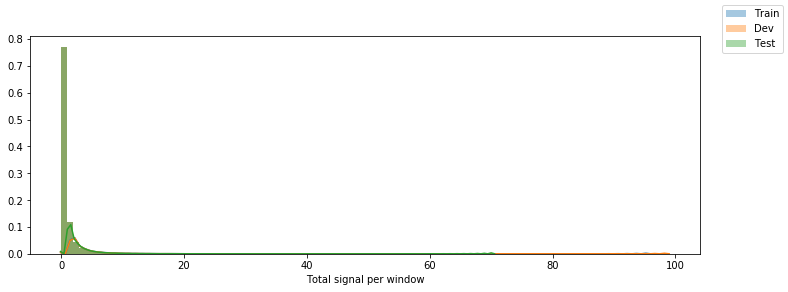

In [27]:
from ae.utils import plot_total_signal

plot_total_signal(dataset, base=base)

## Create training jobs

In [13]:
from jobs import jobs

jobs(
    search_filepath,
    settings_filepath,
    dataset=dataset,
    name=name,
    cluster='cox',
    epochs=2,
    batch_size=256,
    repeat=1,
    base=base,
    clear=True,
    verbose=False
)


Created slurm file for training 1 neural networks


## Check if training finished

In [4]:
from ae.utils import check_status

okay, not_found, outdated = check_status(
    search_name, 'training', dataset=dataset, base=base, show_loss=True
)

print(dataset)

if okay:
    print('Trainings completed')
else:
    print('Trainings did not finish. Missing {}'.format(len(not_found)))
    for nf in not_found:
        print(nf)

encode-dnase_w-12000_f-2_r-100-2019-02-16
Trainings did not finish. Missing 3
../models/cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0---training-encode-dnase_w-12000_f-2_r-100-2019-02-16__0.h5
../models/cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0---training-encode-dnase_w-12000_f-2_r-100-2019-02-16__1.h5
../models/cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0---training-encode-dnase_w-12000_f-2_r-100-2019-02-16__2.h5


In [17]:
import h5py

with h5py.File('../models/cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0---training-encode-dnase-12kb-2019-02-16.h5', 'r') as f:
    print(f['loss'][:])
    print(f['val_loss'][:])
    print(f['times'][:])

[0.25165979 0.2491388 ]
[0.24866414 0.24815006]
[6596.9691956  6555.97395396]


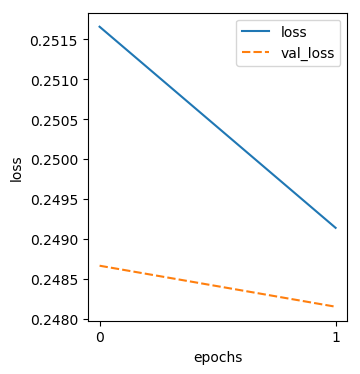

In [15]:
from IPython.display import Image, display

display(Image(filename='../models/cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0---train-loss.png'))

## Create evaluation jobs

In [31]:
from evaluate import create_jobs

create_jobs(
    search_name + '-tmp-test',
    name=name,
    dataset=dataset,
    cluster='seasdgx1',
    base=base,
    incl_dtw=False,
)

Created slurm file for evaluating 1 neural networks


In a terminal run: `sbatch evaluate-cnn-final.slurm`

In [61]:
from ae.utils import check_status

okay, not_found, outdated = check_status(
    search_name + '-tmp-test', 'evaluation', dataset, base=base
)

if okay:
    print('Evaluation completed')
else:
    print('Evaluation did not finish. Missing {}'.format(len(not_found)))

Evaluation completed


## Compare

num_models 1


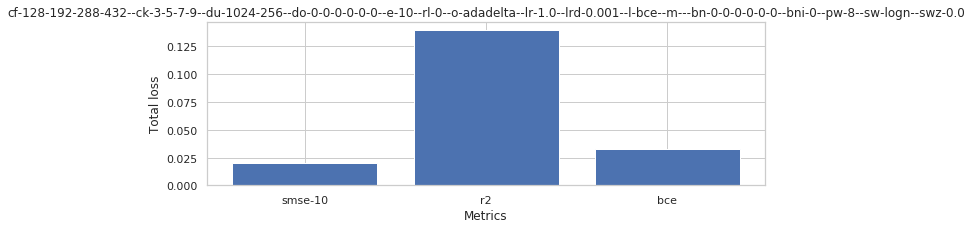

In [67]:
from compare import compare
    
performance = compare(
    'definitions-{}.json'.format(search_name + '-tmp-test'),
    dataset_name=dataset,
    base=base,
    clear=False,
    verbose=False,
    silent=False,
    remove_common_prefix_from_df=True,
)

In [68]:
import qgrid

qgw = qgrid.show_grid(performance)
qgw

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0
../models/cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0---predictions-encode-dnase_w-12000_f-2_r-100-2019-02-16.png


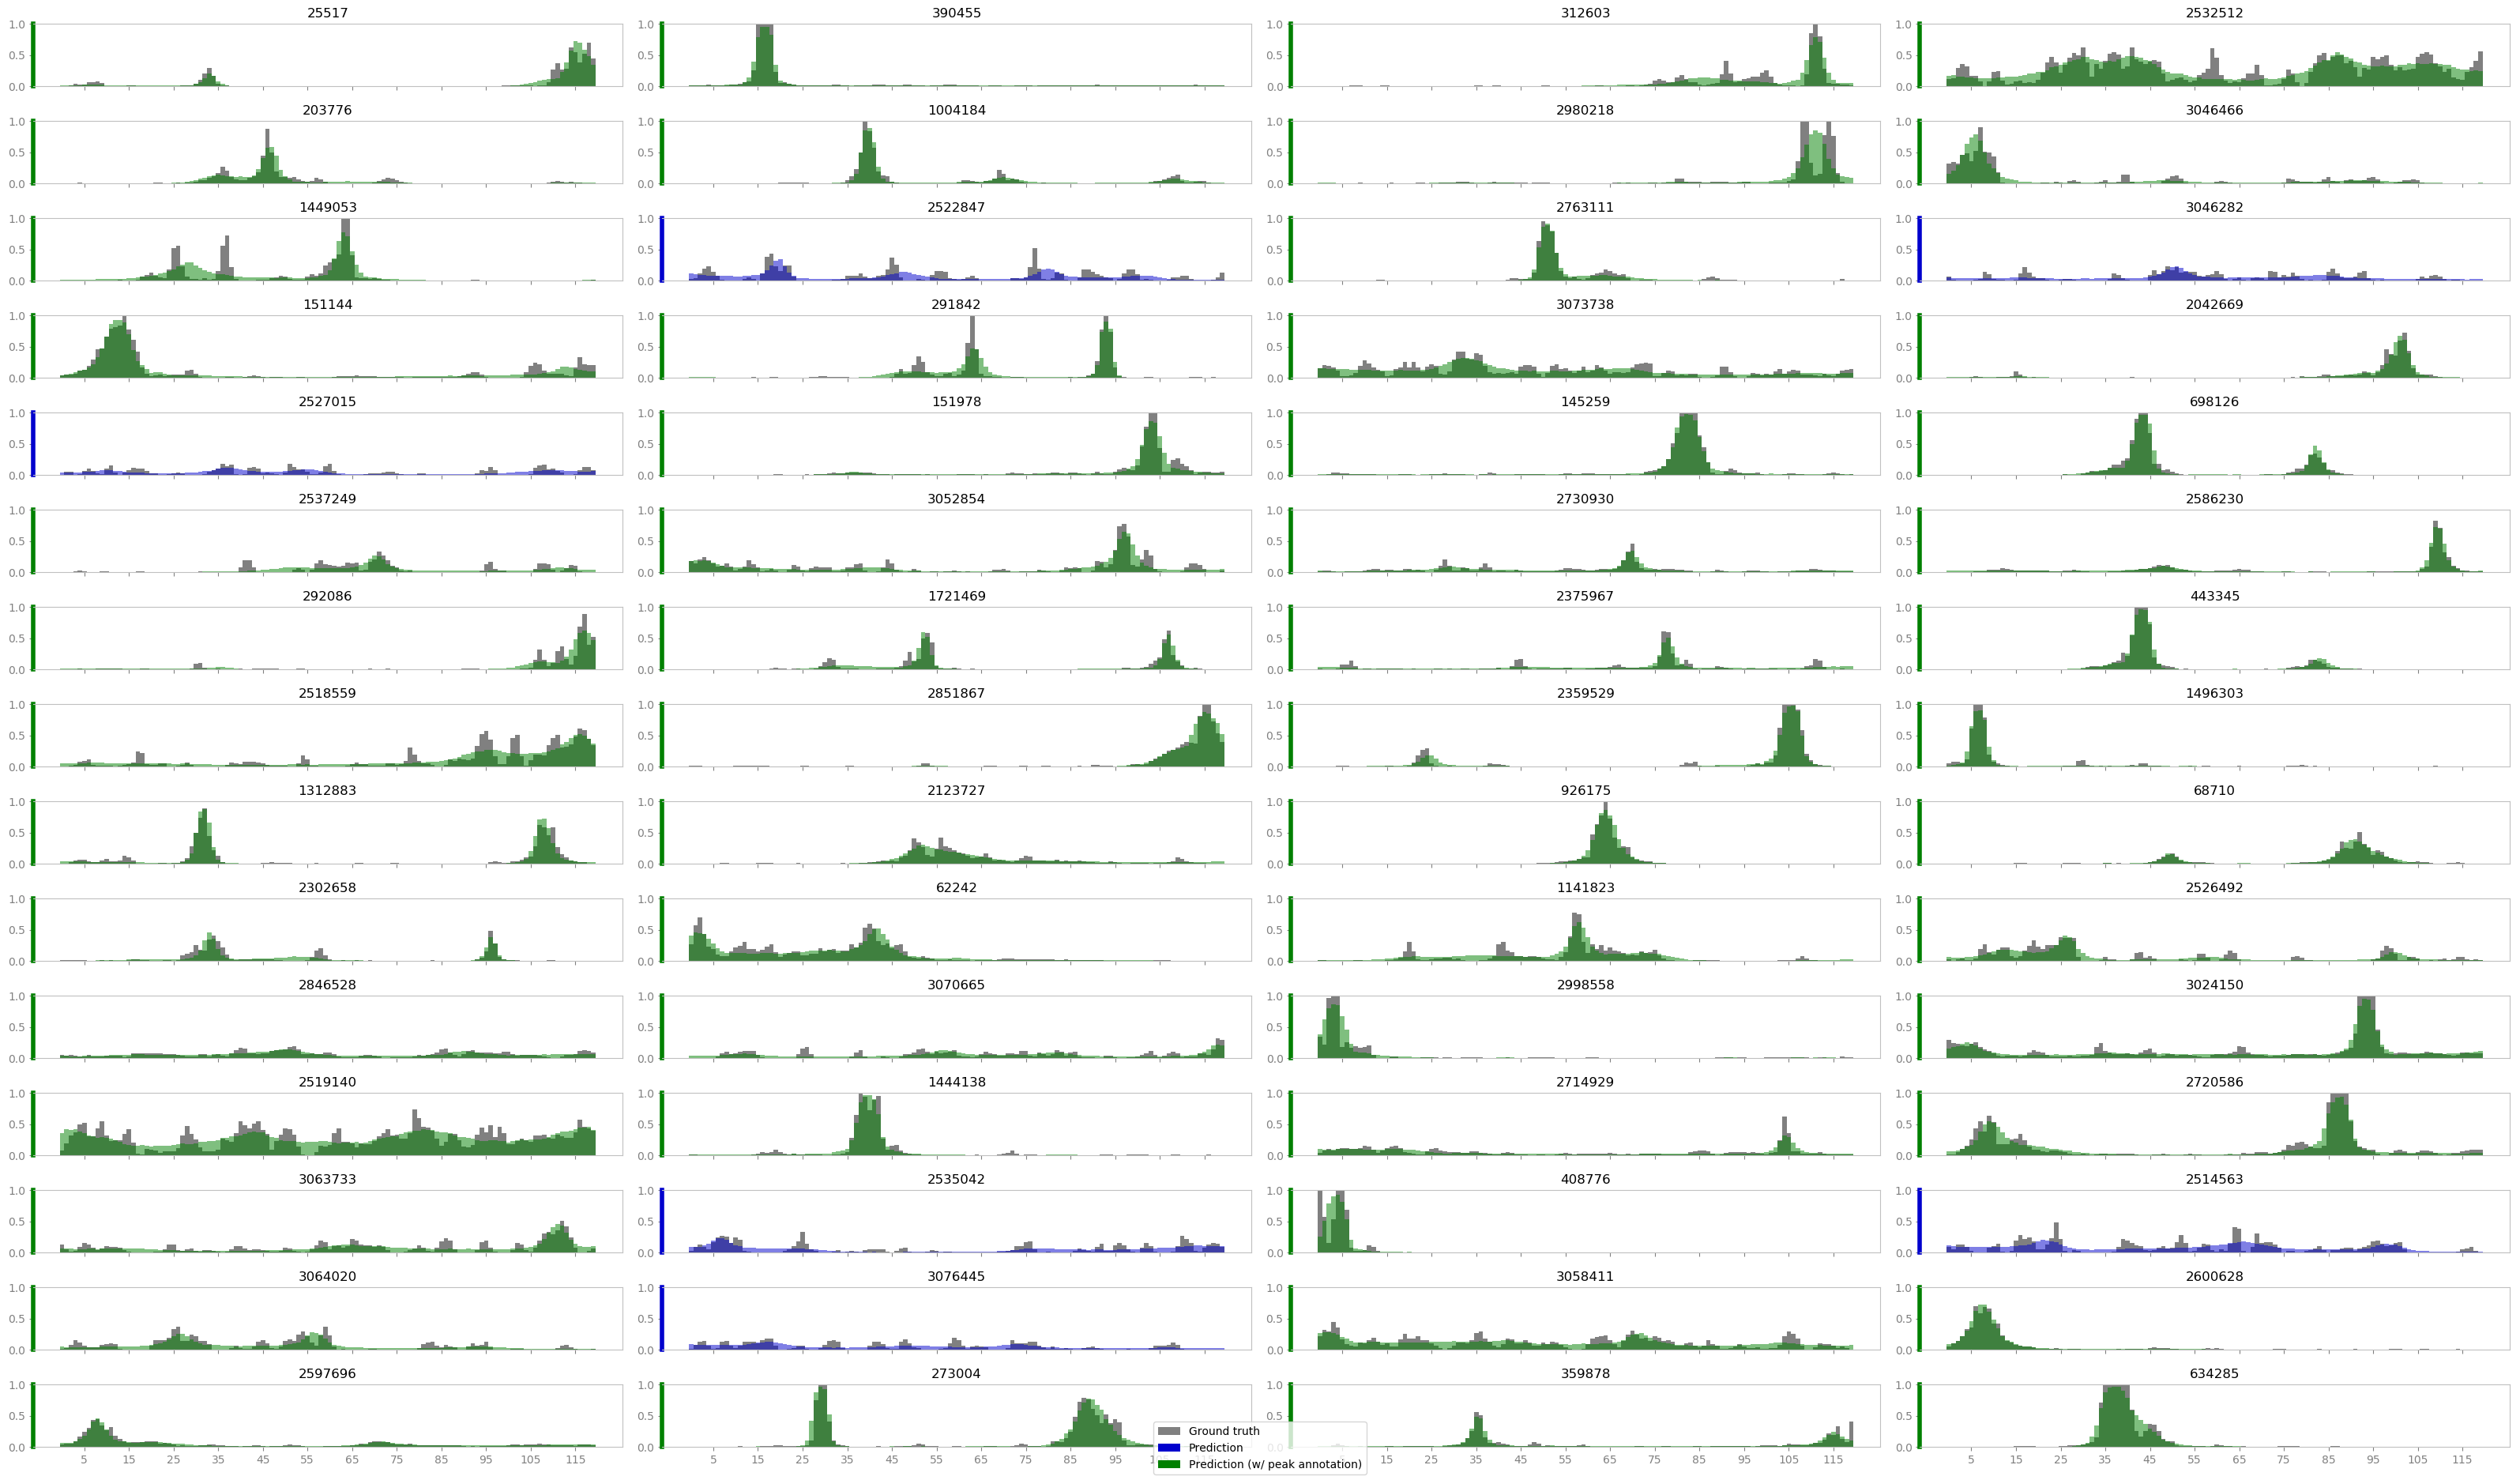

In [74]:
from IPython.core.display import Image, display
from ae.utils import lcp

with open(os.path.join(base, 'definitions-{}.json'.format(search_name + '-tmp-test')), 'r') as f:
    definitions = json.load(f)
    
def_lcp = '' if len(definitions) == 1 else lcp(definitions)

for model in qgw.get_selected_df().iterrows():
    parts = (def_lcp + model[0]).split('__')
    
    model_name = parts[0]
    repetition = ''
    if len(parts) > 1:
        repetition = '__' + parts[1]
        
    filepath = os.path.join(base, 'models', '{}---predictions-{}{}.png'.format(model_name, dataset, repetition))
    
    print(model_name)
#     print(filepath)
    
    display(Image(filepath))

6681 (1.52%) out of 439094 windows are empty


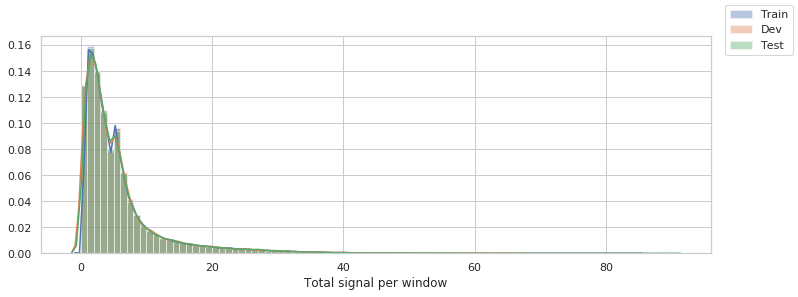

In [120]:
from ae.utils import plot_total_signal

plot_total_signal('ENCSR275ICP_w-3000_f-2_r-25', log=False, base=base)

In [129]:
from prepare import prepare_dnase_only

ENCSR275ICP = {
  "rdn_signal": "ENCFF334GMP",
  "narrow_peaks": "ENCFF306CKD",
  "broad_peaks": "ENCFF412AMQ"
}

data, peaks, selected = prepare_dnase_only(
    ENCSR275ICP,
    settings,
    '../data',
    settings['chromosomes'],
    3000,
    1500,
    verbose = True,
)

Extract windows from ENCFF334GMP.bigWigExtracted 165970 windows from chr1 with a max value of 1.0.
Extracted 161462 windows from chr2 with a max value of 1.0.
Extracted 132197 windows from chr3 with a max value of 1.0.
Extracted 126809 windows from chr4 with a max value of 1.0.
Extracted 121025 windows from chr5 with a max value of 1.0.
Extracted 113870 windows from chr6 with a max value of 1.0.
Extracted 106230 windows from chr7 with a max value of 1.0.
Extracted 96759 windows from chr8 with a max value of 1.0.
Extracted 92263 windows from chr9 with a max value of 1.0.
Extracted 89198 windows from chr10 with a max value of 1.0.
Extracted 90057 windows from chr11 with a max value of 1.0.
Extracted 88850 windows from chr12 with a max value of 1.0.
Extracted 76242 windows from chr13 with a max value of 1.0.
Extracted 71362 windows from chr14 with a max value of 1.0.
Extracted 67994 windows from chr15 with a max value of 1.0.
Extracted 60225 windows from chr16 with a max value of 1.0.
Ext

15328 (9.24%) out of 165970 windows are empty
69234 (49.99%) out of 138497 windows that have no peaks have less than the 5pth percentil signal of windows with peaks


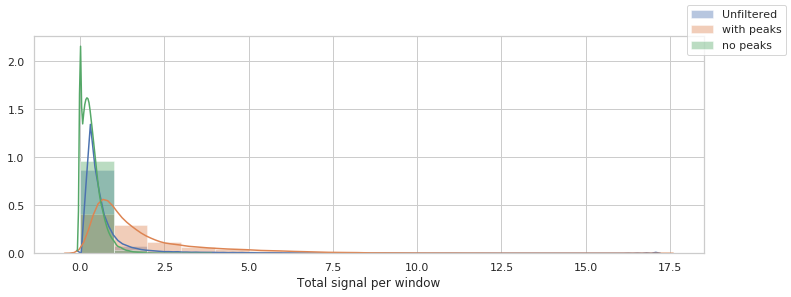

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

total = np.sum(data, axis=1)

num_win = data.shape[0]
num_empty_win = np.sum(total == 0)

win_with_peaks = total[np.arange(peaks.size)[peaks > 0]]
win_no_peaks = total[np.arange(peaks.size)[peaks == 0]]
prtl_5_peaks = np.percentile(win_with_peaks, 5)

less_prtl_5_peaks_win = np.sum((win_no_peaks < prtl_5_peaks) & (win_no_peaks > 0))

print(
    "{} ({:.2f}%) out of {} windows are empty".format(
        num_empty_win, num_empty_win / num_win * 100, num_win
    )
)

print(
    "{} ({:.2f}%) out of {} windows that have no peaks have less than the 5pth percentil signal of windows with peaks".format(
        less_prtl_5_peaks_win, less_prtl_5_peaks_win / win_no_peaks.size * 100, win_no_peaks.size
    )
)

fig = plt.figure(figsize=(12, 4))
sns.distplot(total, bins=np.arange(18), label="Unfiltered", kde=True)
sns.distplot(win_with_peaks, bins=np.arange(18), label="with peaks", kde=True)
sns.distplot(win_no_peaks, bins=np.arange(18), label="no peaks", kde=True)
plt.xlabel("Total signal per window")
fig.legend()

---
---
---

# Re-trained

In [6]:
from ae.utils import check_status

model_name='cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0'

okay, not_found, outdated = check_status(
    search_name,
    'training',
    dataset=dataset,
    base=base,
    re_trained=True,
    model_name=model_name
)

if okay:
    print('Training completed')
else:
    print('Training did not finish. Missing {}'.format(len(not_found)))

Training completed


## Evaluation 

Run `sbatch evaluate-encode-dnase-12kb-retrain.slurm`

In [7]:
from ae.utils import check_status

model_name='cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0'

okay, not_found, outdated = check_status(
    search_name,
    'evaluation',
    dataset=dataset,
    base=base,
    re_trained=True,
    model_name=model_name
)

if okay:
    print('Evaluation completed')
else:
    print('Evaluation did not finish. Missing {}'.format(len(not_found)))

Evaluation completed


[0.01554666 0.09712845 0.03265874]
[[6583.72768509 6558.06541181 6535.04265213 6836.29705977]]


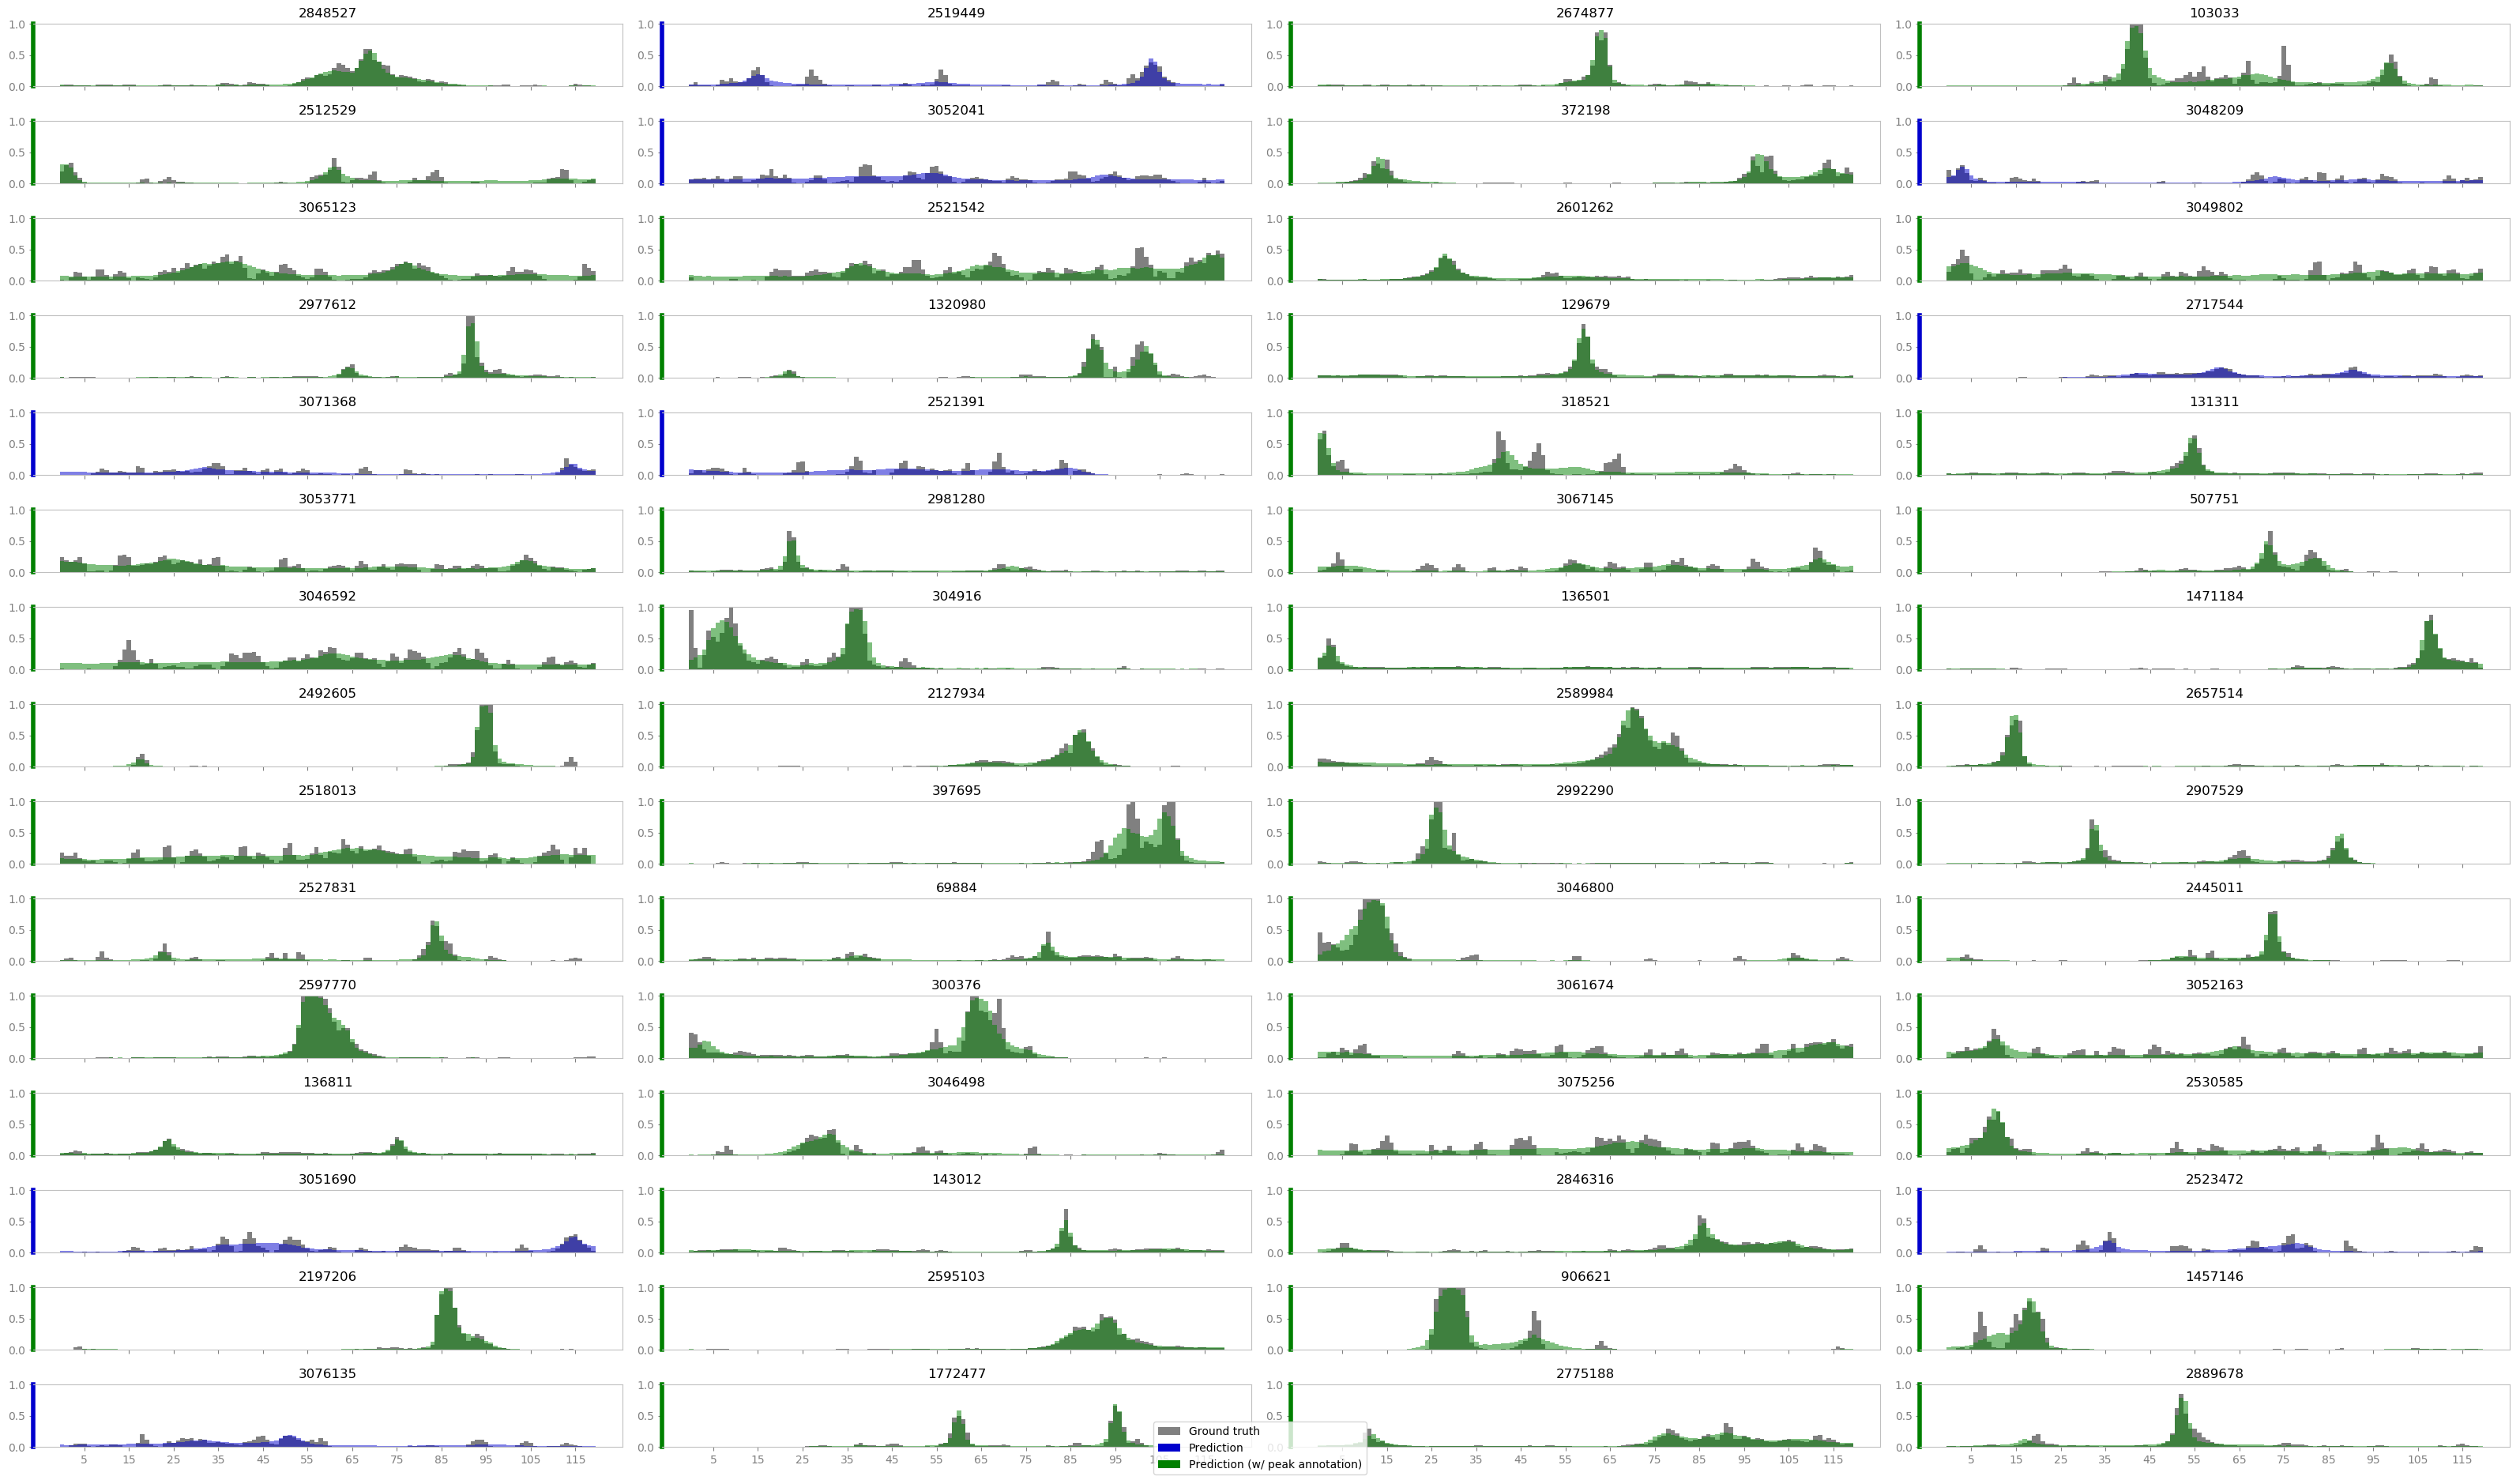

In [11]:
import h5py
from IPython.core.display import Image, display

with h5py.File(os.path.join(base, 'models', '{}---evaluation-{}-re-trained.h5'.format(model_name, dataset)), 'r') as f:
    print(np.mean(f['total_loss'], axis=0))
    print(f['total_times'][:])

display(Image(os.path.join(base, 'models', '{}---predictions-{}-re-trained.png'.format(model_name, dataset))))

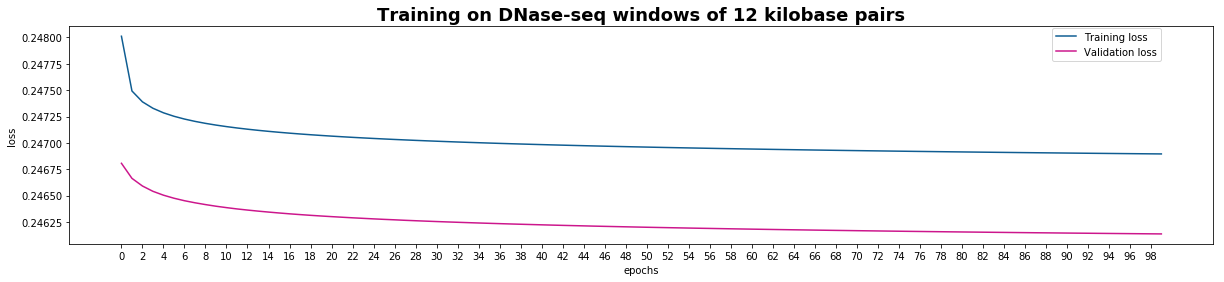

In [14]:
from train import plot_loss_to_file

with h5py.File(os.path.join(base, "models", "{}---training-{}-re-trained.h5".format(model_name, dataset)), "r") as f:
    plot_loss_to_file(
        f['loss'][:],
        f['val_loss'][:],
        model_name,
        dataset_name=dataset,
        title="Training on DNase-seq windows of 12 kilobase pairs",
        base=base,
    )

/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


(array([2521542, 2907529,  103033]),
 array([18.81823733,  6.68677968, 13.44216672]),
 array([0.53068691, 0.71545035, 1.        ]))

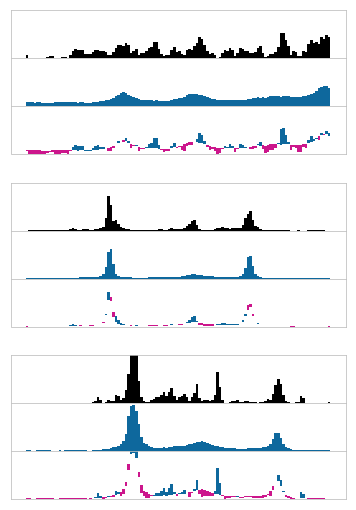

In [2]:
from ae.utils import plot_windows

plot_windows(
    dataset,
    model_name='cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0',
    ds_type="test",
    window_ids=[2521542, 2907529, 103033],
    base=base,
    trained_on_single_dataset=True,
    re_trained=True,
    no_legend=True,
    no_peak_coloring=True,
    diff=True,
    plot_reconst_separately=True,
    no_title=True
)